# Extraction of Spindles from Neocortex recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [17]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
from scipy import stats
from pathlib import Path
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

%matplotlib widget
folder_base = Path('/Users/ahay/Documents/DATA/DREADDthalamus/TestDCZ/2207/20230223/Baseline/')

filename = folder_base / f'LFPwake0.npy'
filename3 = folder_base / f'LFPwakeremoved.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
EMGbooleaninput = folder_base / f'EMGframeBoolean.pkl'

EMGboolean = pd.read_pickle(EMGbooleaninput)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')
All = All
EMGboolean = EMGboolean[:]

PFC = All[:, 11] - All[:, 12] 
PFCwakeremoved = LFPwakeremoved[:,11] - LFPwakeremoved[:,12]
S1 = All[:, 13] - All[:, 14] 
S1wakeremoved = LFPwakeremoved[:,13] - LFPwakeremoved[:,14]
S1 = All[:, 22] - All[:, 23] 
S1wakeremoved = LFPwakeremoved[:,22] - LFPwakeremoved[:,23]
S1.shape

(5697792,)

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [6]:
# Parameter and computation of CWT
fs = 1000
w = 10.
freq = np.linspace(10, 16, 18)
widths = w*fs / (2*freq*np.pi)
#PFCNWcwt = signal.cwt(PFCwakeremoved, signal.morlet2, widths, w=w)
S1NWcwt = signal.cwt(S1wakeremoved, signal.morlet2, widths, w=w)

# Projection calculation PFC
# absPFCNWcwt = np.absolute(PFCNWcwt)
# proj_PFCNWcwt = np.sum(absPFCNWcwt, axis = 0)/24
# sdproj_PFCcwt = np.std(proj_PFCNWcwt)
# sd7proj_PFCcwt = sdproj_PFCcwt*7

# Projection calculation S1
zS1NWcwt = stats.zscore(S1NWcwt, axis=None)
reaS1NWcwt = np.absolute(zS1NWcwt)
proj_S1NWcwt = np.sum(reaS1NWcwt, axis = 0)/24
sdproj_S1cwt = np.std(proj_S1NWcwt)
msdproj_S1cwt = np.mean(proj_S1NWcwt)
sd3proj_S1cwt = msdproj_S1cwt + sdproj_S1cwt*2
sd7proj_S1cwt = msdproj_S1cwt + sdproj_S1cwt*2
sd1proj_S1cwt = msdproj_S1cwt + sdproj_S1cwt



Second on the signal for which wake times have been zeroed

In [18]:

#####################################
########        PFC         #########
#####################################
# Conservative boolean filtering of PFC filtered signal
# BooleanCons = EMGboolean['BooleanConservative']
# fPFCwake0C = filt_PFC.copy()
# fPFCwake0C[BooleanCons] = 0
# PFCwake0C = PFC.copy()
# PFCwake0C[BooleanCons] = 0
# # Liberal boolean filtering of PFC filtered signal
# BooleanLib = EMGboolean['BooleanLiberal']
# fPFCwake0L = filt_PFC.copy()
# fPFCwake0L[BooleanLib] = 0
# PFCwake0L = PFC.copy()
# PFCwake0L[BooleanLib] = 0

# # Computation of CWT
# PFCcwtWake0cons = signal.cwt(fPFCwake0C, signal.morlet2, widths, w=w)
# PFCcwtWake0lib = signal.cwt(fPFCwake0L, signal.morlet2, widths, w=w)

# # Projection calculation
# absPFCW0Ccwt = np.absolute(PFCcwtWake0cons)
# proj_PFCW0Ccwt = np.sum(absPFCW0Ccwt, axis = 0)/24
# absPFCW0Lcwt = np.absolute(PFCcwtWake0lib)
# proj_PFCW0Lcwt = np.sum(absPFCW0Lcwt, axis = 0)/24

#####################################
########         S1         #########
#####################################
# Conservative boolean filtering of S1 filtered signal
BooleanCons = EMGboolean['BooleanConservative']
S1wake0C = S1.copy()
S1wake0C[BooleanCons] = 0
# Liberal boolean filtering of S1 filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
S1wake0L = S1.copy()
S1wake0L[BooleanLib] = 0

# Computation of CWT
S1cwtWake0cons = signal.cwt(S1wake0C, signal.morlet2, widths, w=w)
S1cwtWake0lib = signal.cwt(S1wake0L, signal.morlet2, widths, w=w)

# Projection calculation
# absS1W0Ccwt = np.absolute(S1cwtWake0cons)
# proj_S1W0Ccwt = np.sum(absS1W0Ccwt, axis = 0)/24

# absS1W0Lcwt = np.absolute(S1cwtWake0lib)
# proj_S1W0Lcwt = np.sum(absS1W0Lcwt, axis = 0)/24




In [19]:
zS1W0Ccwt = stats.zscore(S1cwtWake0cons, axis=1)
reaS1W0Ccwt = np.absolute(zS1W0Ccwt)
proj_S1W0Ccwt = np.sum(reaS1W0Ccwt, axis = 0)/24

zS1W0Lcwt = stats.zscore(S1cwtWake0cons, axis=1)
reaS1W0Lcwt = np.absolute(zS1W0Lcwt)
proj_S1W0Lcwt = np.sum(reaS1W0Lcwt, axis = 0)/24

## Extracting Spindles and determining main properties 

First extraction of spindle peaks, initiation, end and width

In [20]:


# Filter parameter :
f_lowcut = 10.
f_hicut = 16.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_S1 = signal.filtfilt(b, a, S1wake0L)



cortex = S1
proj_cortex = proj_S1W0Lcwt
proj_cortexC = proj_S1W0Ccwt
sd_proj_cortex = sd7proj_S1cwt
lib_wake0_cortex = S1cwtWake0lib
filt_cortex = filt_S1

# 7 sd threshold
peaks, properties = find_peaks(proj_cortex, width=200, height=sd7proj_S1cwt)
properties["prominences"], properties["widths"]

# Spindles boundaries taken at 70% from peak of intensity. This means that the spindles with small amplitude will be longer than the big ones.
results_width = peak_widths(proj_cortex, peaks, rel_height=0.6)

# Organise results in numpy array
peaks2 = peaks.reshape(len(peaks),1)
npresults_width = np.array(results_width).reshape(4,-1)
Spindle_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()
print(peaks.shape)



(770,)


Second extraction of main frequency and power 

In [21]:
projMaxP_cwtmg = np.max(lib_wake0_cortex, axis = 0)
projMaxF_cwtmg = np.argmax(lib_wake0_cortex, axis = 0)/2 + 8
projMaxP_cwtmg.shape

nb_Spindles = np.arange(0,len(peaks),1)
data = np.zeros((len(peaks),4))

for tt in nb_Spindles:
    Spindle_start = int(Spindle_prop[3,tt])
    Spindle_stop = int(Spindle_prop[4,tt])
    Spindle_MaxP = projMaxP_cwtmg[Spindle_start:Spindle_stop]
    Spindle_MaxF = projMaxF_cwtmg[Spindle_start:Spindle_stop]
    data[tt, 0] = max(Spindle_MaxF).round()
    data[tt, 1] = max(Spindle_MaxP).round()
    data[tt, 2] = round(sum(Spindle_MaxF)/len(Spindle_MaxF))
    data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))

param_Spindle = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
tSpindle_prop = Spindle_prop.transpose()
pd_prop_Spindle = pd.DataFrame(tSpindle_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
All_Spindle = pd.concat([pd_prop_Spindle, param_Spindle], axis=1)

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_71483/1927274547.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(Spindle_MaxP).round()
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_71483/1927274547.py:16: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_71483/1927274547.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))


In [22]:
nb_spindle = All_Spindle.shape[0]
listtodrop = []
for tt in range(nb_spindle-1):
    if(All_Spindle['end time'][tt]>All_Spindle['start time'][tt + 1]):
        if(All_Spindle['Duration'][tt]<All_Spindle['Duration'][tt + 1]):
            if(All_Spindle['start time'][tt]<All_Spindle['start time'][tt + 1]):
                All_Spindle['start time'][tt+1] = All_Spindle['start time'][tt]
                listtodrop.append(tt)
            else:
                listtodrop.append(tt)
        if(All_Spindle['Duration'][tt]>All_Spindle['Duration'][tt + 1]):
            if(All_Spindle['end time'][tt]<All_Spindle['end time'][tt + 1]):
                All_Spindle['end time'][tt] = All_Spindle['end time'][tt + 1]
                listtodrop.append(tt+1)
            else:
                listtodrop.append(tt+1)

for tt in range(nb_spindle-1):
    if((All_Spindle['start time'][tt + 1] - All_Spindle['end time'][tt])<200):
        if((All_Spindle['Duration'][tt]+300)<All_Spindle['Duration'][tt + 1]):
            All_Spindle['start time'][tt + 1] = All_Spindle['start time'][tt]
            listtodrop.append(tt)
        if((All_Spindle['Duration'][tt+1]+300)<All_Spindle['Duration'][tt]):
            All_Spindle['end time'][tt] = All_Spindle['start time'][tt + 1]
            listtodrop.append(tt+1)

for tt in range(nb_spindle):
    All_Spindle['Duration'][tt]=All_Spindle['end time'][tt]-All_Spindle['start time'][tt]
All_Spindle = All_Spindle.drop(listtodrop) 
print(listtodrop)
All_Spindle.shape[0]

[63, 194, 200, 205, 210, 239, 250, 252, 264, 296, 298, 308, 428, 444, 461, 474, 494, 503, 517, 522, 543, 633, 675, 700, 708, 742, 750, 753, 52, 63, 130, 135, 159, 194, 200, 205, 210, 226, 239, 250, 252, 264, 274, 293, 296, 298, 308, 329, 368, 370, 375, 412, 414, 428, 444, 461, 474, 480, 491, 494, 503, 517, 522, 543, 578, 585, 633, 675, 700, 708, 742, 750, 753, 758]


724

### Store the results in All_Spindle_prop pd dataframe and save as pkl/csv for post processing.

End of Notebook. 

In [23]:
filename2 = folder_base / f'SPINDproperties_PFC.pkl'
filename3 = folder_base / f'SPINDproperties_PFC.csv'
All_Spindle.to_pickle(filename2)
All_Spindle.to_csv(filename3, sep = ',')


combined = np.stack([S1wake0L, proj_S1W0Lcwt], axis = 1)
filenameC = folder_base / f'SignalPFC.npy'
np.save(filenameC, combined)
# if done and no intention to display for assessment
#%reset
#plt.close('all')

### Display

ephys viewer to check Spindle detection

In [24]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([cortex, filt_cortex, proj_cortexC, proj_cortex], axis = 1)

Spindle_peak = peaks
Spindle_start = Spindle_prop[3,:].astype(int)
Spindle_end = Spindle_prop[4,:].astype(int)
Spindle_peak = All_Spindle['peak time'].to_numpy().astype(int)
Spindle_start = All_Spindle['start time'].to_numpy().astype(int)
Spindle_end = All_Spindle['end time'].to_numpy().astype(int)
#Spindle_start = All_Spindle[3,:].astype(int)
#Spindle_end = All_Spindle[4,:].astype(int)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
#and asign them to some channels each
scatter_channels = {0: [1, 2], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'

view1.by_channel_params['ch0', 'gain'] = 0.0003
view1.by_channel_params['ch1', 'gain'] = 0.001
view1.by_channel_params['ch2', 'gain'] = 0.001
view1.by_channel_params['ch3', 'gain'] = 0.001


view1.by_channel_params['ch0', 'offset'] = 1
view1.by_channel_params['ch1', 'offset'] = -1
view1.by_channel_params['ch2', 'offset'] = -1
view1.by_channel_params['ch3', 'offset'] = -1


#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  4.9114227294921875e-05 s
refresh duration for  0.0006060600280761719 s
refresh duration for  0.00033211708068847656 s
refresh duration for  0.0002791881561279297 s
refresh duration for  0.00010919570922851562 s
refresh duration for  0.00011515617370605469 s
refresh duration for  0.0002949237823486328 s
refresh duration for  0.0002601146697998047 s
refresh duration for  0.00032901763916015625 s
refresh duration for  0.00027179718017578125 s
refresh duration for  0.00031185150146484375 s
refresh duration for  0.00028705596923828125 s
refresh duration for  0.0003247261047363281 s
refresh duration for  0.00026988983154296875 s
refresh duration for  0.00031185150146484375 s
refresh duration for  0.0003020763397216797 s
refresh duration for  0.0003020763397216797 s
refresh duration for  0.0002989768981933594 s
refresh duration for  0.00030112266540527344 s
refresh duration for  0.0002560615539550781 s
refresh duration for  0.0003559589385986328 

0

: 

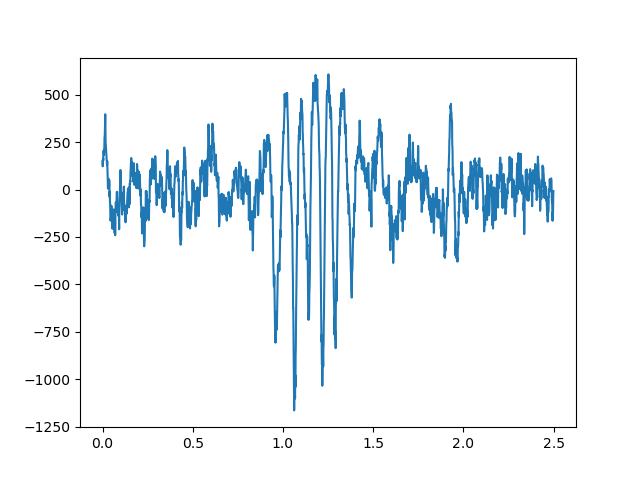

In [55]:
# Defining subset
start = 8141000
end = 8143500

times = np.arange(0, 2500/1000, 1./1000)
tt = times#[start:end]
Cortext = cortex[start:end]

plt.close('all')
plt.plot(tt, Cortext)

plt.show()

filename = folder_base / f'Baseline.svg'
plt.savefig(filename, format="svg")

In [44]:
Cortext = cortex[start:end]
Cortext

array([ 66.10874389,  55.74110323, 347.05790246, ..., -69.46023419,
        22.56964492,  62.37539494])